In [1]:
import pandas as pd
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
import time 

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from lshash.lshash import LSHash

In [2]:
def pre_data():
    #读取文件，整理数据
    df = pd.read_csv('../reco_data/trade.csv')
    df1 = df.groupby([df.vipno, df.pluno])[['amt']].sum()
    
    #这里将data转换为以vipno为行，pluno为列，便于之后处理
    data = df1.unstack(0).fillna(0).round().transpose().loc['amt']
    del data.index.name
    del data.transpose().index.name
    #data_array中每一项代表一个vipno的数组
    data_array = data.as_matrix()
    
    vipno_num = data_array.shape[0]
    vipno_len = data_array.shape[1]
    return data, data_array, vipno_num, vipno_len

In [3]:
def knn(data, data_array, vipno_len, vipno_num, k, vipno_pos, hash_size):
    lsh = LSHash(hash_size, input_dim = vipno_len )
    #将矩阵导入，生成哈希表
    for  vipno in range(vipno_num):
        #将所有vipno导入哈希表，将vipno的值作为extra_data
        lsh.index(data_array[vipno], extra_data =  data.iloc[vipno].name)
    else:
        #得到hash_table的查询结果
        hash_table =  lsh.query(data_array[vipno_pos], num_results= k + 1, distance_func="euclidean")
        result = []
        for res in hash_table:
            result.append(res[0][1])
        else:
            return result[1:]

In [4]:
def question_a(data_array):
    #DBSCAN算法
    eps_array = []
    silhouette_avg_array = []
    for eps in range(50, 120):
        #聚类
        db = DBSCAN(eps = eps, min_samples = 2).fit(data)
        #聚类标签数组
        cluster_labels =  db.labels_
       
        #聚类的个数，标签-1对应的样本表示噪点
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        if(n_clusters < 1):
             print("For eps=", eps, 
                   "All samples are noise")
        else:
            #计算silhouette系数
            silhouette_avg = silhouette_score(data_array, cluster_labels)
            silhouette_avg_array.append(silhouette_avg)
            eps_array.append(eps)
            print("For eps=", eps, 
                  "The number of clusters is:", n_clusters,
                  "The average silhouette_score is:", silhouette_avg)
    
    #绘制图像
    plt.plot(eps_array, silhouette_avg_array, 'r-o')
    plt.xlabel('eps')
    plt.ylabel('average sihouette_score')
    plt.suptitle('silhouette --eps chat')
    plt.show()
    return

In [5]:
def question_b(data, data_array, vipno_num, vipno_len, eps):
    #由a可知
    n_cluster = 2
    #dbscan
    start = time.clock()
    db = DBSCAN(eps = 103, min_samples = 2).fit(data)
    cluster_labels = db.labels_
    db_time = time.clock() - start
    print(cluster_labels)
    
    labels_dic = pd.DataFrame(np.row_stack((data.index, cluster_labels))) 
    labels_dic = labels_dic.transpose().set_index(labels_dic.transpose()[0])
    #随机抽取vipno_pos
    vipno_pos = rd.randint(0,vipno_num)
    for size in [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]:
        for k in [1, 2, 3, 4, 5]:
            #计算knn
            hash_size = int(vipno_num * size)
            start1 = time.clock()
            result = knn(data, data_array, vipno_len, vipno_num, k, vipno_pos, hash_size)
            kn_time = time.clock() - start1
            #results中始终会包含输入
            if len(result) < 1:
                print("for n_cluster = " , n_cluster,
                     ", hash_size = ", hash_size,
                     ", k = ", k,
                     ": no knn output")
            else:
                #判断输入的vipno所在的簇
                input_label = labels_dic.loc[result[0]][1]
                print("for n_cluster = " , n_cluster,
                      ", hash_size = ", hash_size,
                      ", k = ", k,
                      ", vipno_pos = ", vipno_pos,
                      ", knn: ", result)
                #比较输出的vipno
                for res in result:
                    output_label =  labels_dic.loc[res][1]
                    if(input_label == output_label):
                        print("output: ", res, " Same cluster")
                    else:
                        print("output: ", res, " Not same cluster")
    return db_time, kn_time

For eps= 50 The number of clusters is: 2 The average silhouette_score is: -0.212221943267
For eps= 51 The number of clusters is: 2 The average silhouette_score is: -0.207681651962
For eps= 52 The number of clusters is: 2 The average silhouette_score is: -0.207681651962
For eps= 53 The number of clusters is: 3 The average silhouette_score is: -0.209481796945
For eps= 54 The number of clusters is: 3 The average silhouette_score is: -0.20814449635
For eps= 55 The number of clusters is: 3 The average silhouette_score is: -0.20468195202
For eps= 56 The number of clusters is: 3 The average silhouette_score is: -0.199704433904
For eps= 57 The number of clusters is: 2 The average silhouette_score is: -0.194028935983
For eps= 58 The number of clusters is: 2 The average silhouette_score is: -0.187075341787
For eps= 59 The number of clusters is: 2 The average silhouette_score is: -0.182555482035
For eps= 60 The number of clusters is: 2 The average silhouette_score is: -0.178271264861
For eps= 61 

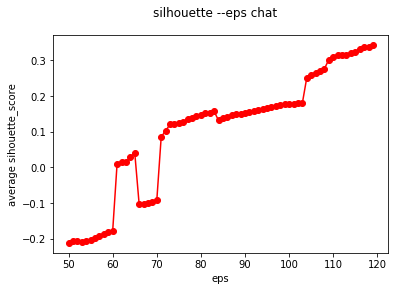

[-1  0 -1 -1  0  0  0 -1  0 -1  0  0 -1  0 -1  0  0  1 -1  0  0  0  0  0  0
 -1  0 -1  0  0 -1  0  0  0  0  0 -1  0  0  0 -1 -1 -1 -1  0  0  0  0 -1  0
  0 -1  0 -1  0  0 -1  0 -1 -1  0  0 -1 -1  0  0 -1 -1 -1  0 -1  0  0 -1  0
 -1 -1 -1  0  0  0  0  0  0  0  0 -1  0  0 -1 -1 -1 -1 -1  0 -1 -1 -1  0  0
  0  0 -1 -1 -1  0  0  0 -1  0 -1 -1  0 -1  0  0 -1  0  0  0  0 -1  0  0 -1
  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0  0
  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1  0 -1  0  0 -1  0  0  0 -1  0  0
 -1  0  0 -1 -1  0  0  0  0  0 -1  0 -1  0  0 -1  0  0 -1  0 -1  0  0 -1  0
  0  0  0 -1  0 -1  0  0 -1  0 -1 -1  0  0  0  0  0 -1 -1 -1 -1  0  0  0  0
  0 -1 -1  0 -1 -1 -1  0  0  0 -1  0 -1  0 -1 -1 -1  0  0 -1  0  0  0 -1 -1
 -1 -1  0 -1  0  0  0 -1  0 -1  0  0 -1  0  0 -1 -1 -1  0  0 -1 -1 -1 -1  0
  0  1 -1 -1 -1 -1  0 -1  0 -1 -1  0 -1  0 -1  0  0 -1  0  0 -1 -1  0]
for n_cluster =  2 , hash_size =  2 , k =  1 , vipno_pos =  91 , knn:  [1595132332932]
output

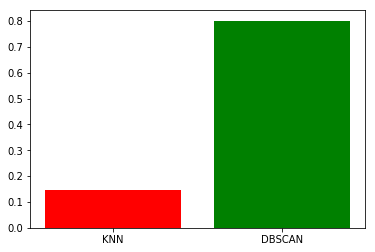

KNN: 0.1453579715884068 DBSCAN: 0.8015721798740176


In [6]:
if __name__ == '__main__':
    data, data_array, vipno_num, vipno_len = pre_data()
    #发现当且仅当min_samples=2时，才能够得出两个以上的聚类，
    #当eps小于100时，能得出两个以上聚类
    #silhouette在[1, 100]区间内随eps递增
    #当eps=103时，得出2个簇，silhouette_score=0.18
    question_a(data_array)
    db_time, kn_time = question_b(data, data_array, vipno_num, vipno_len, eps = 103)
    
    
    name_list = ['KNN','DBSCAN']  
    time_list = [kn_time, db_time]  
    color_list = ['red', 'green']
    plt.bar(range(len(time_list)), time_list,color=color_list,tick_label=name_list)  
    plt.show()  
    print("KNN:", kn_time, "DBSCAN:", db_time)